# Progetto architettura dati

Si vuoule leggere un dataset di applicazioni android, ogni aplicazione è etichettata come "goodware" o "malware" e le feature del dataset sono i permessi richiesti nel manifest dell'applicazione / alcune api call fatte dall'app.

Si vogliono sviluppare i seguenti 2 punti:
1. dimostrare che è possibile predirre correttamente se un applicazione è un malware o goodware in base ai permessi e le api call

In [337]:
# import delle librerie necessarie
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
plt.rcParams['font.family'] = 'Noto Sans Nabataean, Nimbus Sans, Nimbus Roman'

# logistic regression model
from sklearn.linear_model import LogisticRegression

# RFECV
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer

# make random numbers
from random import randint


## Caricare il dataset

Si parte da un dataset con le seguenti feature:
- colonna 1->214: Permission-based features -> sono tutte feature binarie 0=permesso non richiesto, 1=permesso richiesto
- colonna 215->241: API based features -> sono tutte feature binarie 0=api call non richiesta, 1=api call richiesta
- colonna 242: label (target), dove le classi sono:
    - Malware 
    - Goodware

In [338]:
# Lettura del dataset
dataset = pd.read_csv('Dataset/TUANDROMD.csv')

In [339]:
# Mi salvo target e features in variabili diverse
uni_target = dataset[['Label']]
uni_feature = dataset.drop(['Label'], axis=1)

print(uni_target)

         Label
0      malware
1      malware
2      malware
3      malware
4      malware
...        ...
4460  goodware
4461  goodware
4462  goodware
4463  goodware
4464  goodware

[4465 rows x 1 columns]


## Data Exploration
Come primo step controlliamo la numerosità del dataset.

In [340]:
# Mi salvo in una variabile il numero di features per dopo
n_features0 = dataset.shape[1] - 1

# Stampo il numero di records e di features
print(f'Ci sono {dataset.shape[0]} istanze ed un totale di {n_features0} features!')

Ci sono 4465 istanze ed un totale di 241 features!


### Dataset sbilanciato?

Il dataset è sbilanciato? proviamo a fare un **analisi univariata** sui valori di Label per verificare:

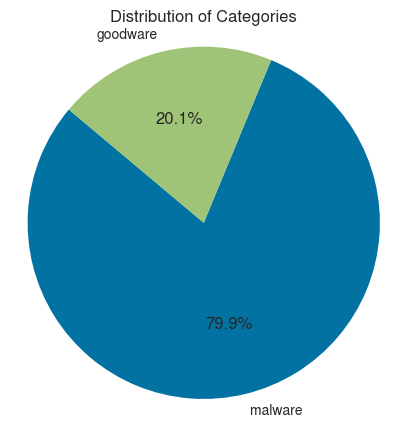

In [341]:
# Conta le occorrenze per ogni valore di Label
label_counts = uni_target['Label'].value_counts()

# Visualizzali in un piechart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')
plt.show()

Per quanto possa non piacerci molto la notizia che il dataset sia sbilanciato (può comportare degli errori bias nella classificazione dei modelli) abbiamo però la buona notizia della sicurezza che il data-set sia binario. 

Sarà quindi necessario utilizzare modelli che offrono buone prestazioni su dataset binari e non troppo suscettibili a dataset sbilanciati. Inoltre **poiché questo set di dati è fortemente sbilanciato, non dobbiamo utilizzare l'accuratezza come parametro di valutazione**, sarebbe meglio invece usare l'F1-score

### Valori mancanti?
Controlliamo ora se il dataset contiene valori mancanti

In [342]:
null_count_features = np.count_nonzero(uni_feature.isna().sum())
print(f"in totale ci sono {null_count_features}/241 features con valori mancanti")

in totale ci sono 241/241 features con valori mancanti


sembra che **tutte** le features contengano almeno un valore nullo.

sviluppiamo quindi una funzione che ci andrà ad elencare tutte le features con valori mancanti in ordine decrescente:

In [343]:
def conteggio_valori_nulli_per_colonna(df):
    colonne_con_valori_nulli = df.columns[df.isnull().any()]
    conteggio_valori_nulli = [(colonna, df[colonna].isnull().sum()) for colonna in colonne_con_valori_nulli]
    conteggio_valori_nulli_sorted = sorted(conteggio_valori_nulli, key=lambda x: x[1], reverse=True)
    
    for colonna, num_valori_nulli in conteggio_valori_nulli_sorted:
        print(f"Colonna '{colonna}': {num_valori_nulli} valori nulli")
        if num_valori_nulli > 0:
            print("Record con valori nulli:")
            records_con_null = df[df[colonna].isnull()]
            for index, row in records_con_null.iterrows():
                print(f"Indice: {index}, Valori: {row.to_dict()}")

In [344]:
print(conteggio_valori_nulli_per_colonna(dataset))

Colonna 'ACCESS_ALL_DOWNLOADS': 1 valori nulli
Record con valori nulli:
Indice: 2533, Valori: {'ACCESS_ALL_DOWNLOADS': nan, 'ACCESS_CACHE_FILESYSTEM': nan, 'ACCESS_CHECKIN_PROPERTIES': nan, 'ACCESS_COARSE_LOCATION': nan, 'ACCESS_COARSE_UPDATES': nan, 'ACCESS_FINE_LOCATION': nan, 'ACCESS_LOCATION_EXTRA_COMMANDS': nan, 'ACCESS_MOCK_LOCATION': nan, 'ACCESS_MTK_MMHW': nan, 'ACCESS_NETWORK_STATE': nan, 'ACCESS_PROVIDER': nan, 'ACCESS_SERVICE': nan, 'ACCESS_SHARED_DATA': nan, 'ACCESS_SUPERUSER': nan, 'ACCESS_SURFACE_FLINGER': nan, 'ACCESS_WIFI_STATE': nan, 'activityCalled': nan, 'ACTIVITY_RECOGNITION': nan, 'ACCOUNT_MANAGER': nan, 'ADD_VOICEMAIL': nan, 'ANT': nan, 'ANT_ADMIN': nan, 'AUTHENTICATE_ACCOUNTS': nan, 'AUTORUN_MANAGER_LICENSE_MANAGER': nan, 'AUTORUN_MANAGER_LICENSE_SERVICE(.autorun)': nan, 'BATTERY_STATS': nan, 'BILLING': nan, 'BIND_ACCESSIBILITY_SERVICE': nan, 'BIND_APPWIDGET': nan, 'BIND_CARRIER_MESSAGING_SERVICE': nan, 'BIND_DEVICE_ADMIN': nan, 'BIND_DREAM_SERVICE': nan, 'BIND_G

Ma in seguito ad un analisi più approfondita (tramite il richiamo della funzione appena definita) ci accorgiamo che è solo la riga 2533 ad avere valori nulli, possiamo dunque eliminarla dal dataset (in quanto non fornisce nessun valore infromativo, tutte le sue feature sono nulle)

In [345]:
# Visto che abbiamo appurato che solo la riga 2533 contiene valori nulli possiamo droppare "tutte" le righe con valori nulli
# mettiamo poi a paragone con il dorppare solo la riga 2533
# se questa operazione torna true abbiamo ulteriore conferma che solo la riga 2533 conteneva valori nulli
print ( dataset.dropna().equals( dataset.drop(2533)) )

True


Dato che l'operazione ritorna true allora possiamo definitivamente eliminare la riga dal dataset e ri-inizializzare le variabili di:
- dataset
- features
- target

In [346]:
dataset = dataset.dropna()
uni_target = dataset[['Label']]
uni_feature = dataset.drop(['Label'], axis=1)

## Modello di validazione

Paradossalmente per vedere se stiamo preparando i dati bene dobbbiamo testare le operazioni di shredding delle feature dataset su dei modelli giocattolo per valutare le performance della feature selection che vengono fatte passo passo, giusto per avere conferma che non stiamo peggiorando le performance della classificazione eleminando troppe fatures.

Nota: siccome stiamo usando un data-set sbilanciano è bene se ci basiamo sull' F1-score invece che sull'accuracy. 

Nota2: si scieglie appositamente di usare 2 modelli per la classificazione dei dati:
- **Logistic Regression**: un modello molto ben prestante alla presenza di un dataset sbilanciato e con molte feature (che quindi ci aspettiamo funzioni molto bene fin da subito)
- **Naive bayes**: un modello molto soggetto a bias, specialmente quando il dataset è sbilanciato (che ci aspettiamo quindi performi male prima di scolgere la preparazione dati)

In [347]:
# standard scaler
from sklearn.preprocessing import StandardScaler

# to keep track of training time
import datetime

# logistic regression - naive bayes model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# metrics used for evaluation
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt

# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix, ROCAUC

# KNN imputation
from sklearn.impute import KNNImputer

# normalizer
from sklearn.preprocessing import Normalizer

# variance threshold
from sklearn.feature_selection import VarianceThreshold

In [348]:
#prima sostituisco nel target dei valori numerici 0 ed 1 alle stringhe "goodware" e "malware"
uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])
print(uni_target)

X_train, X_test, y_train, y_test = train_test_split(uni_feature, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

      Label
0         0
1         0
2         0
3         0
4         0
...     ...
4460      1
4461      1
4462      1
4463      1
4464      1

[4464 rows x 1 columns]


/tmp/ipykernel_51459/2910749984.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])


In [349]:
def evaluate_with_Logistic_Regression(train_df, test_df, train_target, test_target):
    
    # Standard scaling
    scaler = StandardScaler()
    scaler.fit(train_df)
    train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
    
    print("==========================================================================================================")
    print("")
    print(" _                 _     _   _        _____                              _             ")
    print("| |               (_)   | | (_)      |  __ \                            (_)             ")
    print("| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  ")
    print("| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ ")
    print("| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |")
    print("|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|")
    print("              __/ |                               __/ |                                ")
    print("             |___/                               |___/                                ")


    # Logistic Regression model
    logreg = LogisticRegression(random_state=42, class_weight='balanced', C=200, dual=False, solver='liblinear')
    start_time = datetime.datetime.now()
    logreg.fit(train_std, train_target.values.ravel())
    elapsed = datetime.datetime.now() - start_time
    time = int(elapsed.total_seconds()*1000)
    
    # Evaluation and scoring for Logistic Regression
    y_pred_logreg = logreg.predict(test_std)
    y_true = test_target.values.ravel()
    f1score_logreg = f1_score(y_true, y_pred_logreg, average='micro')
    mccscore_logreg = matthews_corrcoef(y_true, y_pred_logreg)
    precision_logreg = precision_score(y_true, y_pred_logreg, average='micro')
    
    # Visualizations for Logistic Regression
    cre_logreg = ClassPredictionError(logreg, classes=['malware', 'goodware'])
    cre_logreg.score(test_std, y_true)
    cre_logreg.show()
    
    cm_logreg = ConfusionMatrix(logreg, classes=['malware', 'goodware'])
    cm_logreg.score(test_std, y_true)
    cm_logreg.show()
    
    rocauc_logreg = RocCurveDisplay.from_estimator(logreg, test_std, y_true)
    plt.show()

    return {
        "logreg": {
            "time": time,
            "f1score": f1score_logreg,
            "mccscore": mccscore_logreg,
            "precision": precision_logreg
        }
    }


In [350]:
def print_results_logreg(results_logreg):
    print("==========================================================================================================")
    print()
    print("Logistic Regression Results:")
    print(f"Time: {results_logreg['time']} ms")
    print(f"F1 Score: {results_logreg['f1score']:.2f}")
    print(f"MCC Score: {results_logreg['mccscore']:.2f}")
    print(f"Precision: {results_logreg['precision']:.2f}")
    print()
    print("==========================================================================================================")

In [351]:
def evaluate_with_Naive_Bayes(train_df, test_df, train_target, test_target):
    
    # Standard scaling
    scaler = StandardScaler()
    scaler.fit(train_df)
    train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)    

    print("==========================================================================================================")
    print("")
    print(" _   _       _             ____                        ")
    print("| \ | |     (_)           |  _ \                       ")
    print("|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ ")
    print("| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|")
    print("| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ ")
    print("|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/")
    print("                                        __/ | ")
    print("                                       |___/ ")
    
    # Naive Bayes model
    nb = GaussianNB()
    start_time = datetime.datetime.now()
    nb.fit(train_std, train_target.values.ravel())
    elapsed = datetime.datetime.now() - start_time
    time = int(elapsed.total_seconds()*1000)
    
    # Evaluation and scoring for Naive Bayes
    y_true = test_target.values.ravel()
    y_pred_nb = nb.predict(test_std)
    f1score_nb = f1_score(y_true, y_pred_nb, average='micro')
    mccscore_nb = matthews_corrcoef(y_true, y_pred_nb)
    precision_nb = precision_score(y_true, y_pred_nb, average='micro')
    
    # Visualizations for Naive Bayes
    cre_nb = ClassPredictionError(nb, classes=['malware', 'goodware'])
    cre_nb.score(test_std, y_true)
    cre_nb.show()
    
    cm_nb = ConfusionMatrix(nb, classes=['malware', 'goodware'])
    cm_nb.score(test_std, y_true)
    cm_nb.show()
    
    rocauc_nb = RocCurveDisplay.from_estimator(nb, test_std, y_true)
    plt.show()

    return {
        "naive_bayes": {
            "time": time,
            "f1score": f1score_nb,
            "mccscore": mccscore_nb,
            "precision": precision_nb
        }
    }

In [352]:
def print_results_nb(results_nb):    
    
    print("==========================================================================================================")
    print()
    print("Naive Bayes Results:")
    print(f"Time: {results_nb['time']} ms")
    print(f"F1 Score: {results_nb['f1score']:.2f}")
    print(f"MCC Score: {results_nb['mccscore']:.2f}")
    print(f"Precision: {results_nb['precision']:.2f}")
    print()
    print("==========================================================================================================")

In [353]:
def evaluate(X_train, X_test, y_train, y_test):
    # lists to record time and scores
    f1scores = []
    mccscores = []
    times = []

    results_logreg = evaluate_with_Logistic_Regression(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)["logreg"]
    results_nb = evaluate_with_Naive_Bayes(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)["naive_bayes"]

    print_results_logreg(results_logreg)
    print()
    print()
    print_results_nb(results_nb)


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


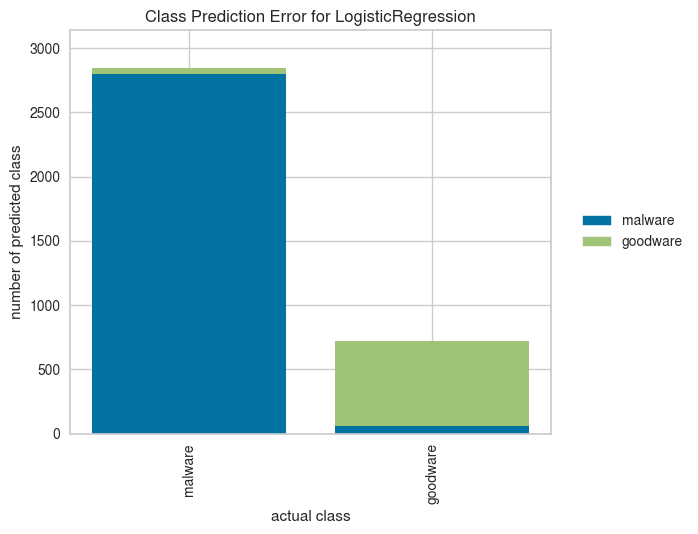

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


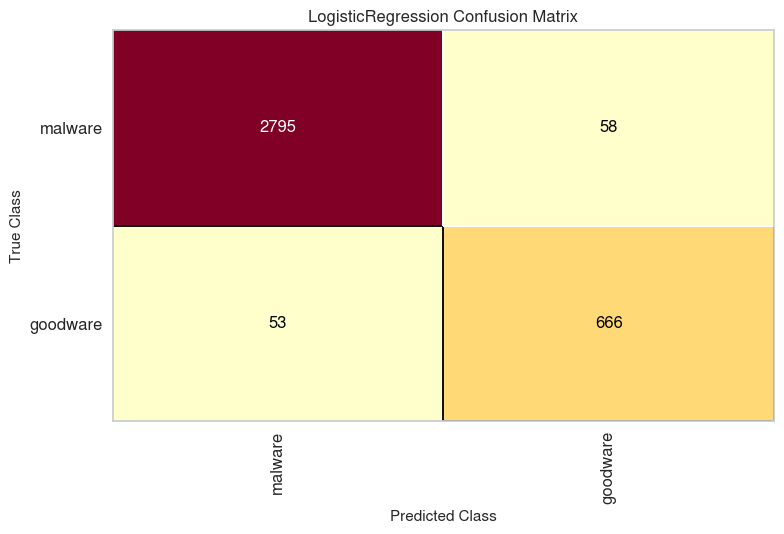

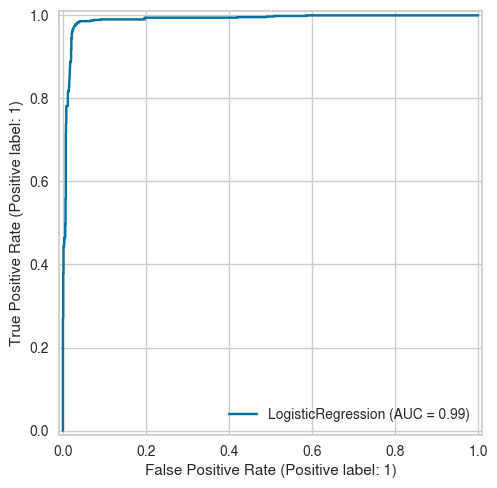


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


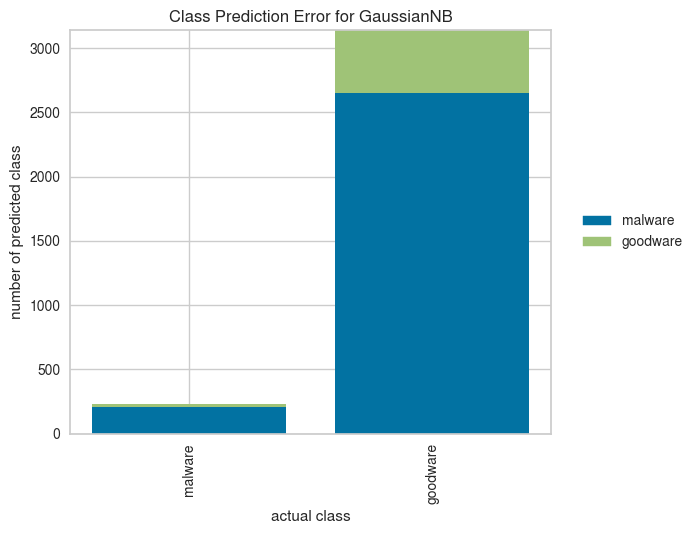

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


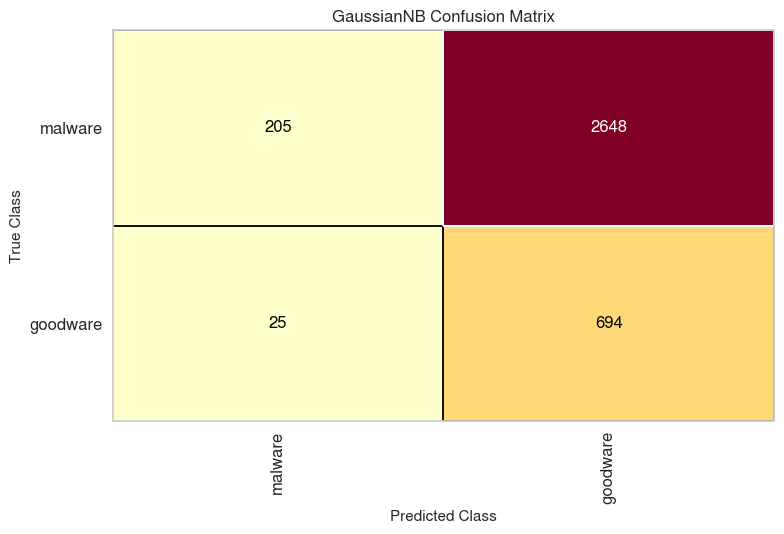

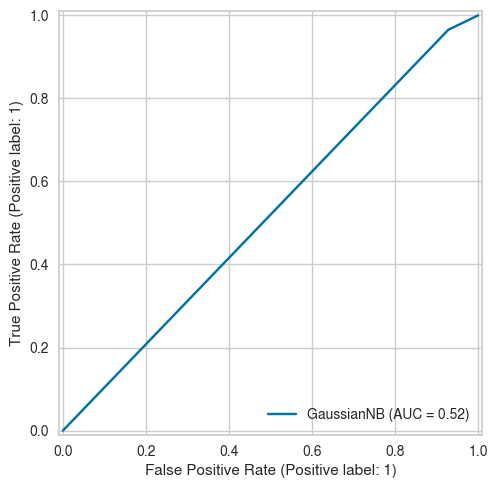


Logistic Regression Results:
Time: 98 ms
F1 Score: 0.97
MCC Score: 0.90
Precision: 0.97




Naive Bayes Results:
Time: 10 ms
F1 Score: 0.25
MCC Score: 0.06
Precision: 0.25



In [354]:
evaluate(X_train, X_test, y_train, y_test)

Dai plot appena mostrati riusciamo a concludere che nonostante ci siamo molte features, riusciamo comunque a valture tutto il dataset in tempi accettabili.
Questo ci piace anche se siamo a conoscenza del fatto che dovessimo avere più istanze nel nostro dataset il tempo di predizione non scalerebbe per niente bene. Siccome noi però non dobbiamo fare altro che creare un modello giocattolo per vedere se eliminando alcune feature dal dataset riusciamo a mantenere lo f1-score questa cosa ci va bene.

Inoltre, esattamente come ci aspettavamo, spicca molto la differenza di performance di classificazzione dei due algoritmi: laddove la logistic regression fin da subito riesce ad ottenere degli ottimi risultati di classificazione (che rasentano il classificatore perfetto) invece il modello naive bayes, come ci aspettavamo, diventa un classificatore casuale. 

## Preparazione dei dati

In questa fase andremo a dimostrare come pulire i dati, in particolar modo fare feature extraction per far rimanere solo le feature più importanti alla classificazione,possa migliorare moltissimo le prestazioni del modello naive bayes (rendendolo più simile al modello di regressione logistica a) ed inoltre anche velicizzare di molto entrambi i tempi di predizione per entrambi i modelli (rendendo le soluzioni più scalabili)

Si noti però che questo non è il nostro fine ultimo. Noi vogliamo fare feature extracion delle feature più importanti per poi andare a sperimentare come i due modelli si dovessero comportare nel caso in cui queste feature venissero "sporcate" (passaggio che verrà eseguito nella sezione successiva)

In [355]:
# Per la prima operazione di selezione delle feature partiamo dall'avere tutte le feature come feature più importanti
most_important_features = uni_feature

### Analisi bivariata della correlazione - Eliminazione feature ridondanti

Il coefficiente di correlazione ha valori compresi tra -1 e 1
- Un valore più vicino allo 0 implica una correlazione più debole (0 esatto implica nessuna correlazione)
- Un valore più vicino a 1 implica una correlazione positiva più forte
- Un valore più vicino a -1 implica una correlazione negativa più forte

Se due features indipendenti (indipendenti = non target) hanno una correlazione assoluta elevata, le informazioni che offrono per il nostro modello ML sono sostanzialmente le stesse.

Le funzionalità correlate in generale non migliorano i modelli, quindi se ne può eliminarne una, in quanto è ridondante. Con la seguente funzione possiamo selezionare fature altamente correlate (correlate ad un altra feature al 95%)

In [356]:
# nota: la funzione rimuoverà la PRIMA feature correlata a qualsiasi altra feature
def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # siamo interessati al valore assoluto del coeff
                colname = corr_matrix.columns[i]  # si prende la stringa del nome della colonna
                col_corr.add(colname)
    return col_corr

**Nota**: calcoliamo prima la divisione in train e test set perchè volgiamo applicare il metodo di eliminazione delle feature ridondanti appena definito **solo sul train set** per poi verificare, tramite validazione con i modelli, produca buoni risulati anche sul test set. Se si andasse immediatamente ad applicare la rimozione della feature direttamente su tutto il dataset si causerebbe overfitting.

Seguriemo questa prcedura di divisione del dataset di `most_important_features` in train e test per validare le performance su anche tutte le elaborazioni seguenti

In [357]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

In [358]:
non_correlated_features = correlation(X_train, 0.95) #da qui si imposta che voglio threshold di correlazione minimo 95%
# Ossia tutte le feature che sono correlate ad un altra feature per almeno il 95% vengono eliminate

# Inizializzo variabile delle feature meno importanti
less_important_features = non_correlated_features

# Aggiornamento delle variabili di test e trai dopo aver calcolato le feature da droppare
X_train = X_train.drop(non_correlated_features, axis=1)
X_test = X_test.drop(non_correlated_features, axis=1)

n_correlated_features = X_train.shape[1]

print(f'Dopo aver droppato {len(non_correlated_features)} features, rimangono {n_correlated_features} features.')
print("Features droppate:")
print(non_correlated_features)

Dopo aver droppato 75 features, rimangono 166 features.
Features droppate:
{'BROADCAST_SMS', 'LOCATION_HARDWARE', 'READ_FRAME_BUFFER', 'REORDER_TASKS', 'MEDIA_CONTENT_CONTROL', 'BIND_TEXT_SERVICE', 'PERSISTENT_ACTIVITY', 'BIND_INPUT_METHOD', 'WRITE_VOICEMAIL', 'BIND_NFC_SERVICE', 'DELETE_CACHE_FILES', 'WRITE_HISTORY_BOOKMARKS', 'SET_TIME_ZONE', 'CONTROL_LOCATION_UPDATES', 'INSTALL_SHORTCUT', 'BIND_goodwareTIFICATION_LISTENER_SERVICE', 'CHANGE_COMPONENT_ENABLED_STATE', 'SET_PROCESS_LIMIT', 'BIND_WALLPAPER', 'FORCE_BACK', 'BIND_DREAM_SERVICE', 'SET_POINTER_SPEED', 'RECEIVE_MMS', 'SET_ALARM', 'UNINSTALL_SHORTCUT', 'BROADCAST_WAP_PUSH', 'DEVICE_POWER', 'SET_ALWAYS_FINISH', 'UPDATE_DEVICE_STATS', 'WRITE_GSERVICES', 'CAPTURE_VIDEO_OUTPUT', 'INJECT_EVENTS', 'READ_HISTORY_BOOKMARKS', 'GET_TOP_ACTIVITY_INFO', 'WRITE_USER_DICTIONARY', 'WRITE_PROFILE', 'CAPTURE_SECURE_VIDEO_OUTPUT', 'WRITE_SOCIAL_STREAM', 'INTERNAL_SYSTEM_WINDOW', 'RECEIVE_WAP_PUSH', 'READ_SOCIAL_STREAM', 'BIND_CARRIER_MESSAGING_


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


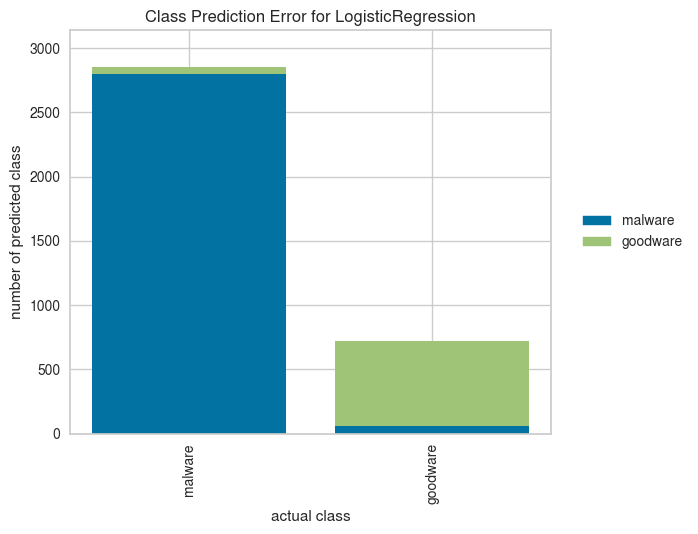

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


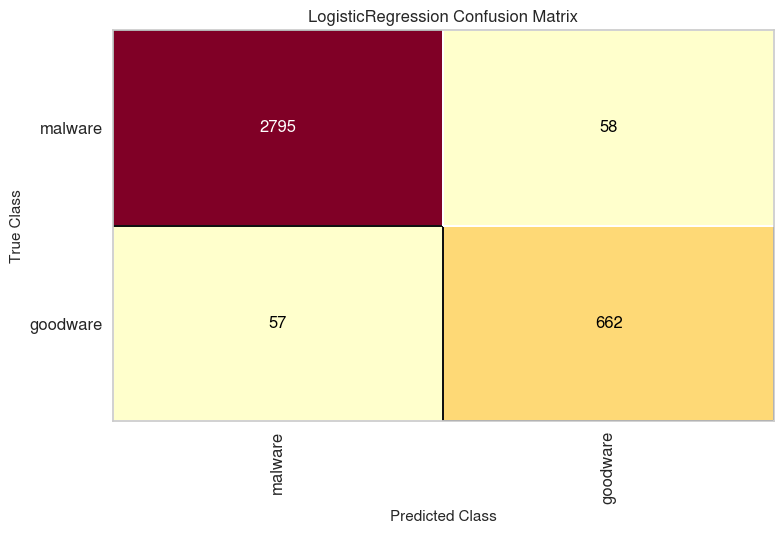

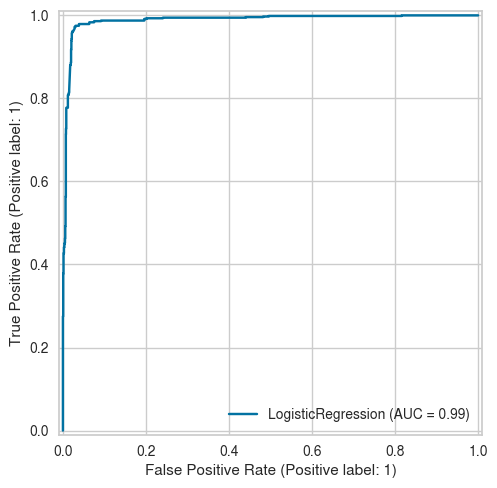


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


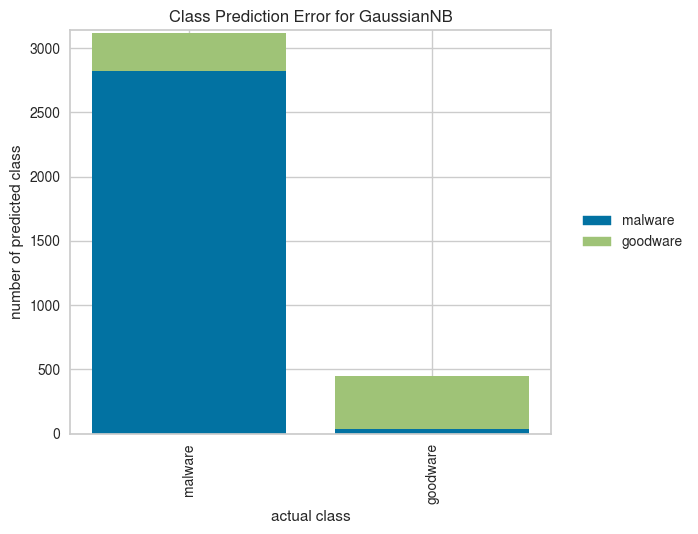

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


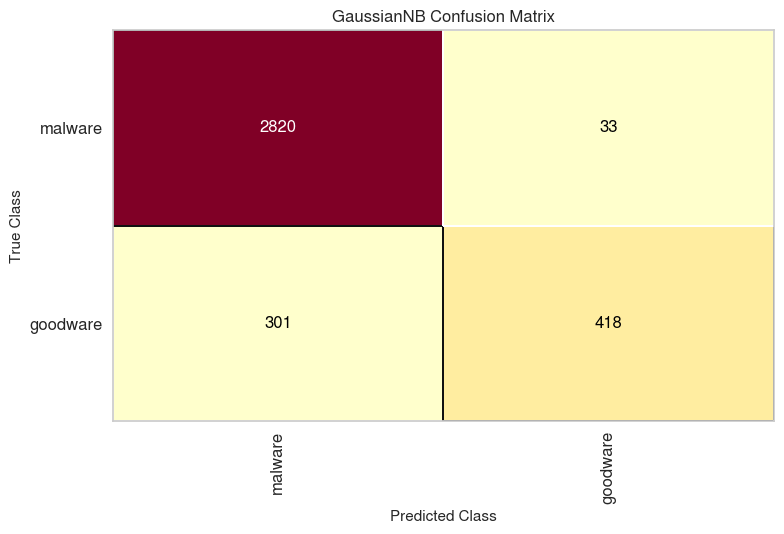

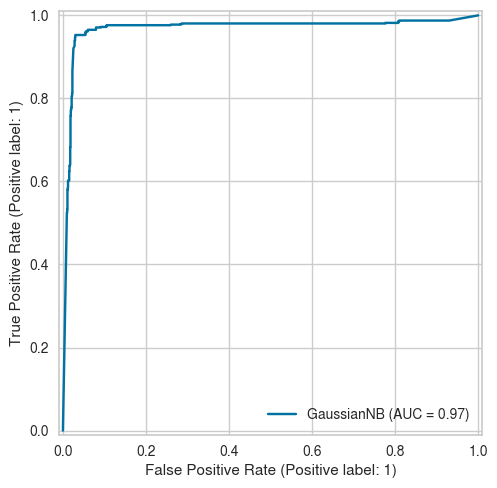


Logistic Regression Results:
Time: 59 ms
F1 Score: 0.97
MCC Score: 0.90
Precision: 0.97




Naive Bayes Results:
Time: 12 ms
F1 Score: 0.91
MCC Score: 0.69
Precision: 0.91



In [359]:
evaluate(X_train, X_test, y_train, y_test)

Dato che abbiamo appurato che la funzione da buoni risultati possiamo aggironare quindi la variabile delle dataset di `most_important_features` (contente solo le fature più importanti) come segue:

In [360]:
# Inizializzazione varibile feature più importanti
most_important_features = most_important_features.drop(non_correlated_features, axis=1)
most_important_features_columns = most_important_features.columns

### Analisi bivariata della correlazione - Highlight delle feature più importanti

A differenza della correlazione a coppie vista prima, in cui è desiderabile una correlazione bassa tra due feature diverse, in questo caso vorremmo che le nostre features avessero un'elevata correlazione con il target. Se una feature ha una bassa correlazione con il target, significa che non è una funzionalità utile per prevedere il target e, pertanto, dovrebbe essere rimossa. 

La seguente funzione calcolerà la correlazione di ciascuna feature con il target e poi restituirà le colonne che hanno una correlazione inferiore alla soglia scelta.

In [361]:
def corrwith_target(dataframe, target, threshold):
    cor = dataframe.corr()
    # Calcolo Correlazione con il target
    cor_target = abs(cor[target])
    # Seleziona le features non correlate
    # se non supera la soglia 'threshold' goodwareata come parametro si aggiunge la colonna all'elelenco di colonne da scartare
    relevant_features = cor_target[cor_target<threshold]
    return relevant_features.index.tolist()[:-1]

Di seguito, come anticipato, divisione del dataset di `most_important_features` in train e test per poi validare le performance della lavorazione che si vuole applicare: 

In [362]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

In [363]:
# Si deve creare una variabile di test-set dummy (che contiene anche il target) per far girare il metodo appena creato
dummy_train = X_train.copy()
dummy_train['Label'] = y_train

In [364]:
#facciamo rimanere le colonne che hanno correlazione con il target superiore a 5%
corrwith_cols = corrwith_target(dummy_train, 'Label', 0.05)

# Aggiunta delle feature meno importanti ritrovate a questo passaggio
less_important_features.update( corrwith_cols )

# Aggiornamento delle feature più importanti 
# (si droppano quelle meno importanti appena trovate da quelle most_important trovate precedentemente)
# Crea un set di nomi delle colonne più importanti
most_important_features_columns = set(most_important_features.columns)
# Trova l'intersezione tra most_important_features - corrwith_cols
common_columns = most_important_features_columns.intersection(corrwith_cols)

# Droppa le colonne da most_important_features se ce ne sono
if common_columns:
    X_train.drop(columns=common_columns, inplace=True)
    X_test.drop(columns=common_columns, inplace=True)

n_correlated_features = X_train.shape[1]

print(f'Dopo aver droppato in totale {len(less_important_features)} features, rimangono {n_correlated_features} features.')
print("Colonne droppate in questa operazione:")
print(corrwith_cols)

Dopo aver droppato in totale 108 features, rimangono 133 features.
Colonne droppate in questa operazione:
['ACCESS_CHECKIN_PROPERTIES', 'ACCESS_COARSE_UPDATES', 'ACCESS_LOCATION_EXTRA_COMMANDS', 'ACCESS_MOCK_LOCATION', 'ACCESS_SUPERUSER', 'ACCOUNT_MANAGER', 'BATTERY_STATS', 'BIND_ACCESSIBILITY_SERVICE', 'BODY_SENSORS', 'BROADCAST_STICKY', 'CHANGE_CONFIGURATION', 'CHANGE_WIFI_MULTICAST_STATE', 'CLEAR_APP_CACHE', 'CLEAR_APP_USER_DATA', 'DUMP', 'EXPAND_STATUS_BAR', 'FACTORY_TEST', 'INSTALL_LOCATION_PROVIDER', 'MASTER_CLEAR', 'MODIFY_PHONE_STATE', 'MOUNT_FORMAT_FILESYSTEMS', 'NFC', 'PROCESS_OUTGOING_CALLS', 'READ_CALL_LOG', 'READ_CONTACTS', 'READ_EXTERNAL_STORAGE', 'READ_PROFILE', 'READ_SYNC_STATS', 'READ_USER_DICTIONARY', 'SET_ACTIVITY_WATCHER', 'SET_WALLPAPER_HINTS', 'WRITE_SETTINGS', 'Ljava/lang/Runtime;->exec']



 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


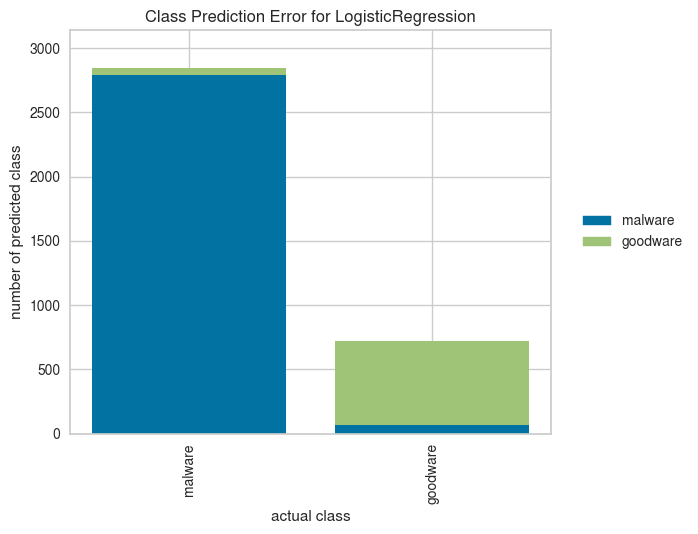

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


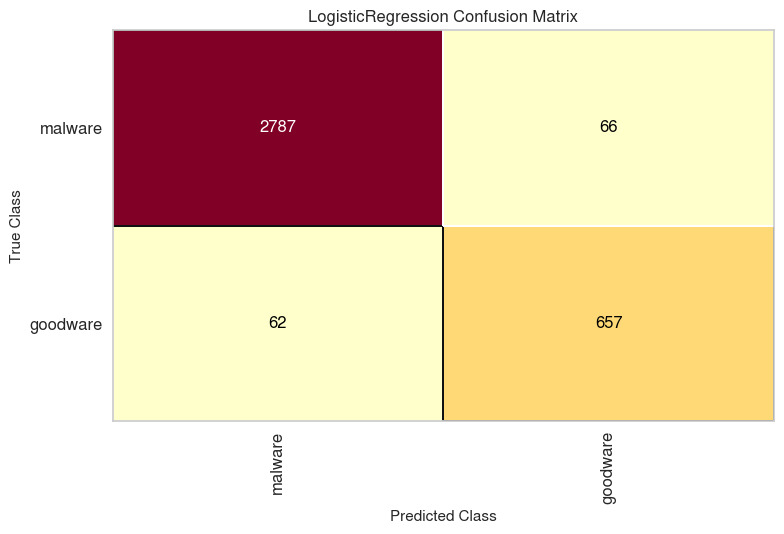

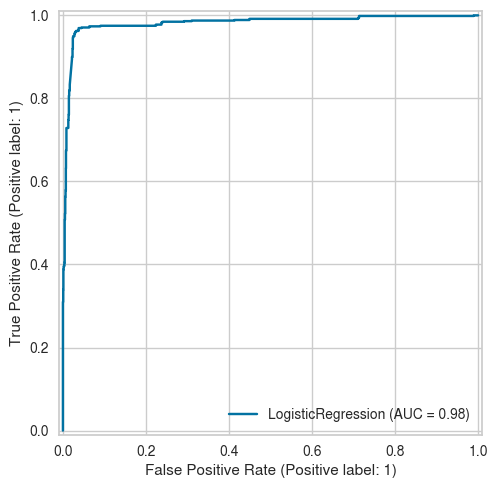


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


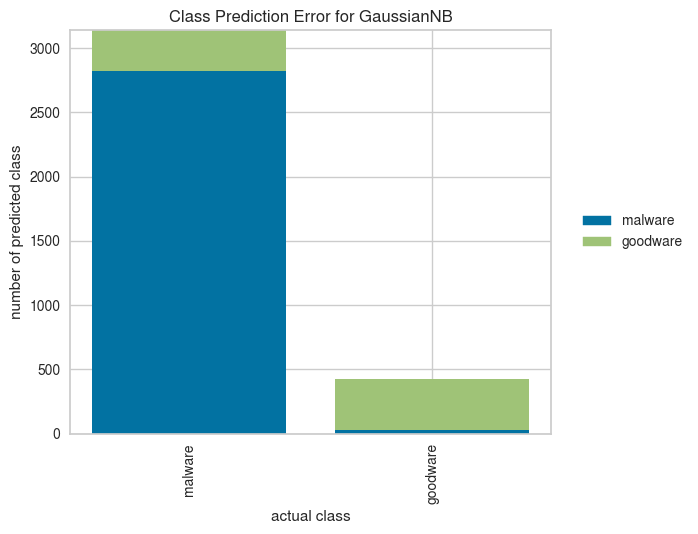

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


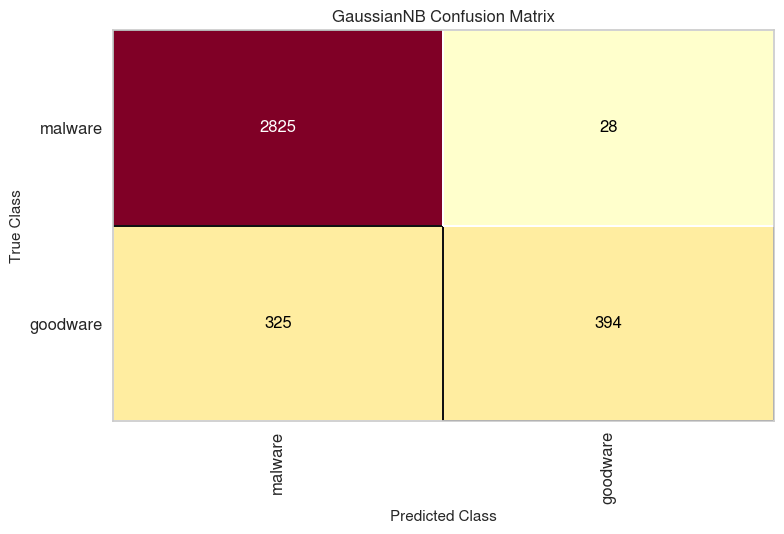

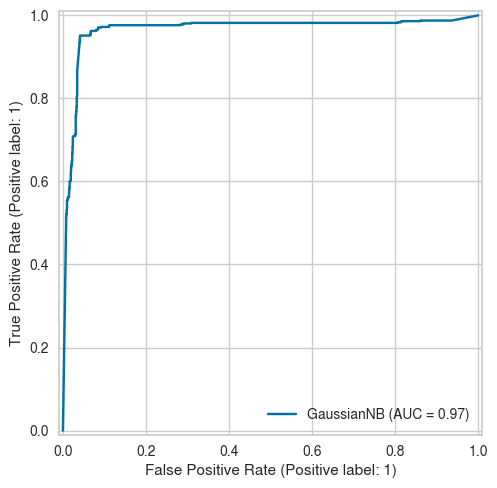


Logistic Regression Results:
Time: 44 ms
F1 Score: 0.96
MCC Score: 0.89
Precision: 0.96




Naive Bayes Results:
Time: 8 ms
F1 Score: 0.90
MCC Score: 0.67
Precision: 0.90



In [365]:
evaluate(X_train, X_test, y_train, y_test)

In [366]:
# Dopo aver dimostrato il funzionamento possiamo droppare le colonne da most_important_features (che ricordiamo è una variabile contiene le istanze)
if common_columns:
    most_important_features.drop(columns=common_columns, inplace=True)

most_important_features_columns = most_important_features.columns

### RFE-CV (Recursive feature elimination)

RFE prende in input il modello al quale vogliamo applicare i dati ed il train set. Questa tecnica, come indica il nome, effettua le seguenti fasi:

1. **Selezione iterativa delle feature**: RFE opera selezionando iterativamente un sottoinsieme di feature dal dataset. Inizia con tutte le feature nel dataset e addestra il modello su di esse.

2. **Valutazione delle feature**: Dopo aver addestrato il modello, viene calcolata una metrica di importanza delle feature, che può essere basata su coefficienti (nel caso della regressione lineare, per esempio), importanza delle variabili (nel caso degli alberi decisionali) o altre metriche rilevanti per il tipo di modello utilizzato.

3. **Eliminazione delle feature meno importanti**: Dalle feature attualmente selezionate, RFE rimuove quelle che sono considerate meno importanti secondo la metrica di importanza definita.

4. **Valutazione delle prestazioni**: il modello viene valutato utilizzando il sottoinsieme ottimale di feature selezionate tramite RFE.

5. **Ripetizione**: Il processo viene ripetuto ricorsivamente con un numero inferiore di feature, continuando fino a raggiungere un numero prefissato di feature o fino a quando il miglioramento delle prestazioni del modello non è significativo.


Il vantaggio principale di RFE è che permette di ottenere un modello più semplice e interpretabile, mantenendo allo stesso tempo o migliorando le prestazioni predictive. Rimuovendo le feature meno informative, si riduce anche il rischio di overfitting, specialmente in presenza di un gran numero di feature rispetto al numero di osservazioni nel dataset. 

Tuttavia, è importante notare che RFE può richiedere un tempo di calcolo significativo, specialmente con dataset molto grandi e complessi (essendo un metodo ricorsivo non scala bene). Noi avremmo potuto applicare RFE fin da subito (senza applicare le elaborazioni precedenti) ma in quel caso i tempi di computazione sarebbero diventanti non accdetabili (intorno ai 40 minuti). Invece dopo la selezione che abbiamo effettuato abbiamo un elaborazione di RFE in circa 2 minuti, che è sempre tanto ma a noi va bene comunque perchè questo è un modello giocattolo

In [367]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

Nota: in questo caso noi applichiamo RFE per ottenere un miglioramento delle prestazioni solo sul modello di Logistic Regression per 2 motivi: 
1. Computare un miglioramento delle prestazioni su entrambi i modelli costerebbe troppo tempo
2. Se si ha un miglioramento sul modello di Logistic Regression lo si ha sicuramente anche sul modello Naive Bayes 

Ma per essere pianamente sicuri, come sempre, applichiamo prima la trasformazione di RFE solo sul train set e validiamo i risultati facendo predizione con entrambi i modelli 

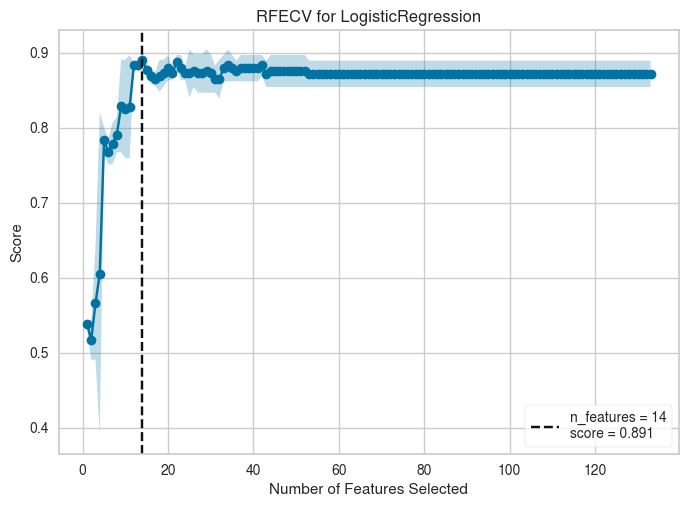

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [368]:
# Visualize the data
mcc_scorer = make_scorer(matthews_corrcoef)
rfecv = RFECV(estimator=LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'),
              cv=StratifiedKFold(2),
              scoring =  mcc_scorer)
rfecv.fit(X_train, y_train.values.ravel())
rfecv.show() 

In [369]:
mask = rfecv.get_support()

#variabile tmp per avere tutte le colonne
columns = X_train.columns

#variabile con colonne selezionate / non selezionate da RFE 
# Aggiunta delle feature meno importanti ritrovate a questo passaggio
less_important_features.update( columns[~mask] ) 
most_important_features_columns = columns[mask]

# Aggiornamento delle variabili di test e trai dopo aver calcolato le feature da droppare
X_train = pd.DataFrame(rfecv.transform(X_train), columns = most_important_features_columns)
X_test = pd.DataFrame(rfecv.transform(X_test), columns = most_important_features_columns)

print(f'Dopo aver droppato in totale {len(less_important_features)} features, rimangono {X_train.shape[1]} features.')
print("Colonne droppate in questa operazione:")
print(less_important_features)

Dopo aver droppato in totale 227 features, rimangono 14 features.
Colonne droppate in questa operazione:
{'READ_CONTACTS', 'WRITE_CALENDAR', 'REORDER_TASKS', 'MEDIA_CONTENT_CONTROL', 'Landroid/telephony/TelephonyManager;->getSimOperatorName', 'Landroid/telephony/TelephonyManager;->getNetworkOperatorName', 'WRITE_SECURE_SETTINGS', 'SET_TIME_ZONE', 'Lcom/google/android/gms/location/LocationClient;->getLastLocation', 'ACCESS_PROVIDER', 'READ_SYNC_SETTINGS', 'CHANGE_COMPONENT_ENABLED_STATE', 'DATABASE_INTERFACE_SERVICE', 'BIND_DREAM_SERVICE', 'SET_POINTER_SPEED', 'Ljava/lang/Runtime;->exec', 'RECEIVE_MMS', 'SET_ALARM', 'WRITE_GSERVICES', 'BROADCAST_WAP_PUSH', 'READ_AVESTTINGS', 'Landroid/telephony/TelephonyManager;->getCellLocation', 'WRITE_APN_SETTINGS', 'DOWNLOAD_SERVICE', 'ACCESS_COARSE_UPDATES', 'MESSAGE', 'INTERNAL_SYSTEM_WINDOW', 'RECEIVE_WAP_PUSH', 'FACTORY_TEST', 'READ_SOCIAL_STREAM', 'RECEIVE_SIGNED_DATA_RESULT', 'Landroid/telephony/TelephonyManager;->getNetworkOperator', 'ACCESS_

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(
/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(



 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


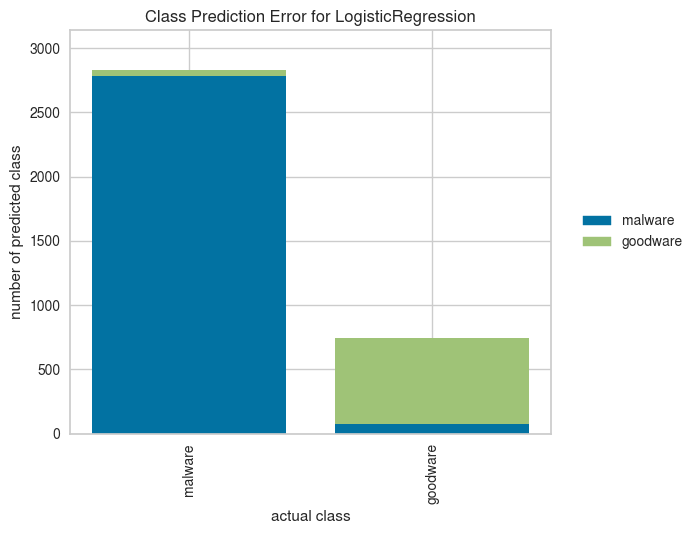

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


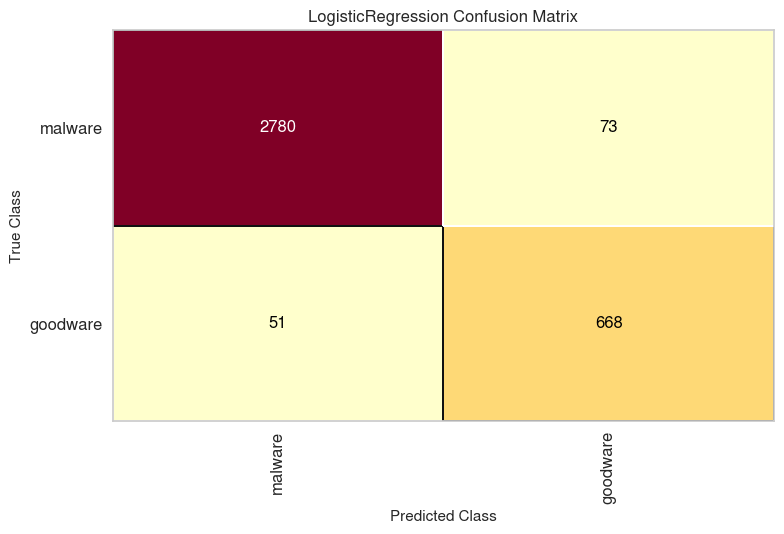

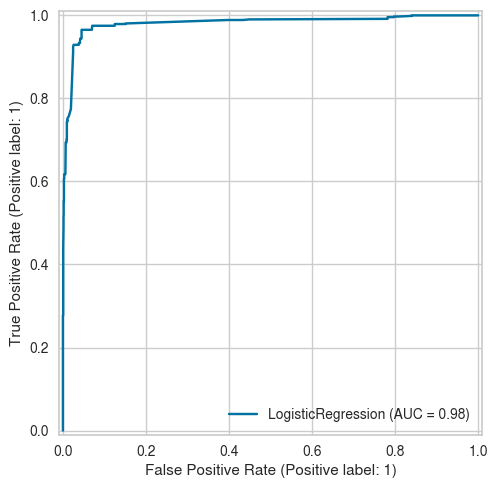


 _   _       _             ____                        
| \ | |     (_)           |  _ \                       
|  \| | __ _ ___   _____  | |_) | __ _ _   _  ___  ___ 
| . ` |/ _` | \ \ / / _ \ |  _ < / _` | | | |/ _ \/ __|
| |\  | (_| | |\ V /  __/ | |_) | (_| | |_| |  __/\__ \ 
|_| \_|\__,_|_| \_/ \___| |____/ \__,_|\__, |\___||___/
                                        __/ | 
                                       |___/ 


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


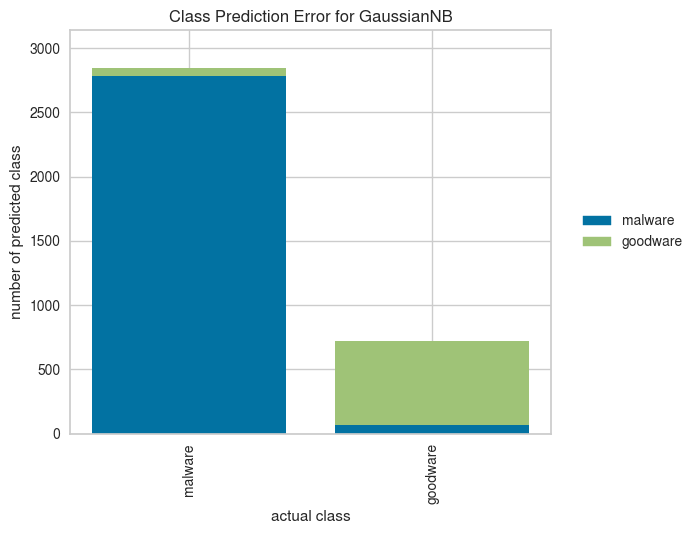

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


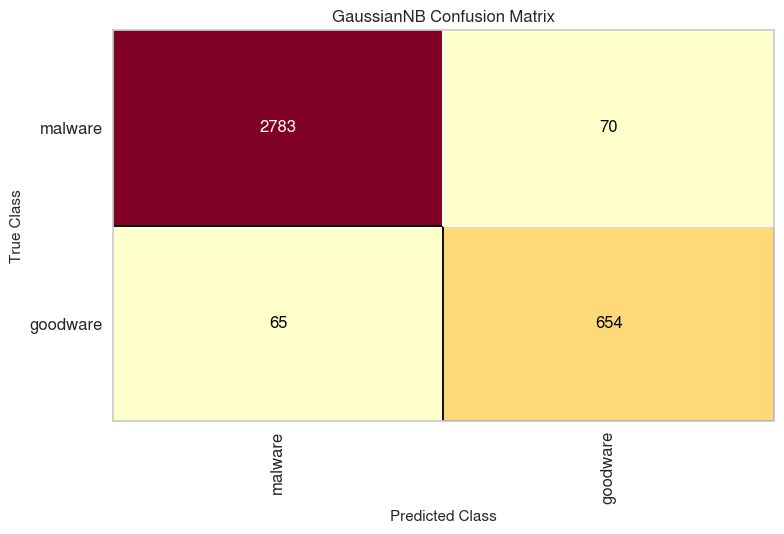

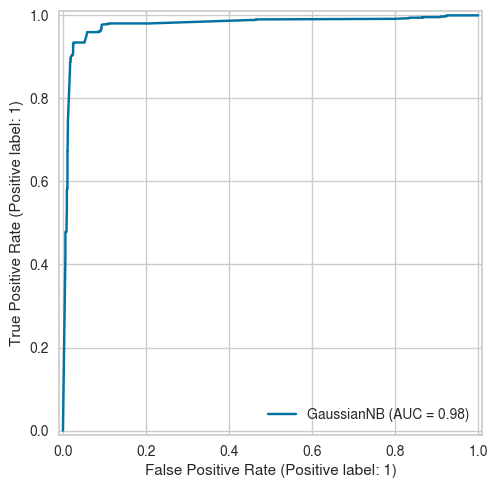


Logistic Regression Results:
Time: 13 ms
F1 Score: 0.97
MCC Score: 0.89
Precision: 0.97




Naive Bayes Results:
Time: 3 ms
F1 Score: 0.96
MCC Score: 0.88
Precision: 0.96



In [370]:
evaluate(X_train, X_test, y_train, y_test)

In [371]:
# Dopo che abbiamo appurato che produce buoni risultati possiamo aggiornare il dataset contenente solo le feature più importanti
most_important_features = most_important_features[most_important_features_columns]
most_important_features_columns = most_important_features.columns

## PCA

In [372]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [373]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(most_important_features)

scaled_data

array([[-0.24201745, -0.22051257, -0.16691592, ..., -0.46798078,
        -0.28941008, -0.31758957],
       [-0.24201745, -0.22051257, -0.16691592, ..., -0.46798078,
        -0.28941008,  3.14871806],
       [-0.24201745, -0.22051257, -0.16691592, ..., -0.46798078,
        -0.28941008, -0.31758957],
       ...,
       [-0.24201745, -0.22051257, -0.16691592, ..., -0.46798078,
        -0.28941008, -0.31758957],
       [-0.24201745, -0.22051257, -0.16691592, ...,  2.13683991,
        -0.28941008, -0.31758957],
       [-0.24201745, -0.22051257, -0.16691592, ...,  2.13683991,
        -0.28941008, -0.31758957]])

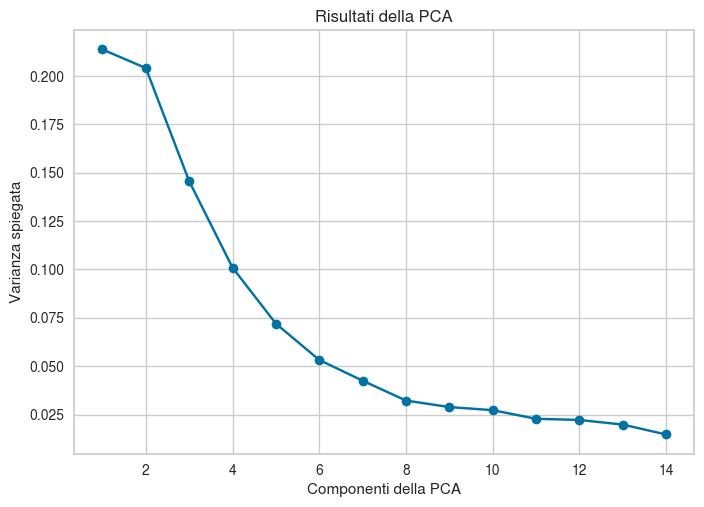

In [374]:
pca = PCA().fit(scaled_data)

# Crea un grafico della varianza spiegata per ogni componente
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()

La varianza spiegata rappresenta la quantità di variazione nei dati originariamente presenti nei dati e catturati da ciascuna componente principale. 

Vogliamo cercare di trovare il numero minimo di componenti principali che spieghino una quantità significativa della varianza nei dati. Questo può essere determinato osservando il grafico della varianza spiegata e cercando il "gomito" nella curva, dove l'aggiunta di ulteriori componenti principali non contribuisce significativamente a spiegare la varianza.

Potremmo ora noi scegliere di mostrare solo tra i primi 30 e 50 risultati

In [375]:
# Applica la PCA per ridurre la dimensionalità dei dati
pca = PCA(n_components=10).fit(scaled_data)
pca_data = pca.transform(scaled_data)

In [376]:
# Quantifichiamo  la percentuale di varianza spiegata da ciascuno delle componenti.
print(pca.explained_variance_ratio_)

[0.21371012 0.20410943 0.14563145 0.10092941 0.07200375 0.05321893
 0.04250508 0.03224931 0.02886486 0.02725967]


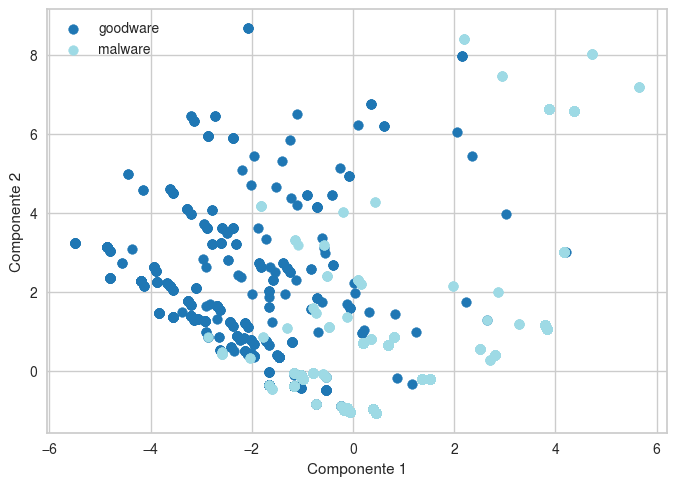

In [377]:
# crea una mappa etichetta-->codice colore
unique_labels = np.unique(dataset["Label"])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

# genera il grafico
fig, ax = plt.subplots()
for label in unique_labels:
    mask = (dataset["Label"] == label).values
    ax.scatter(pca_data[mask, 0], pca_data[mask, 1], color=label_to_color[label], label=label)

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')

ax.legend()

plt.show()

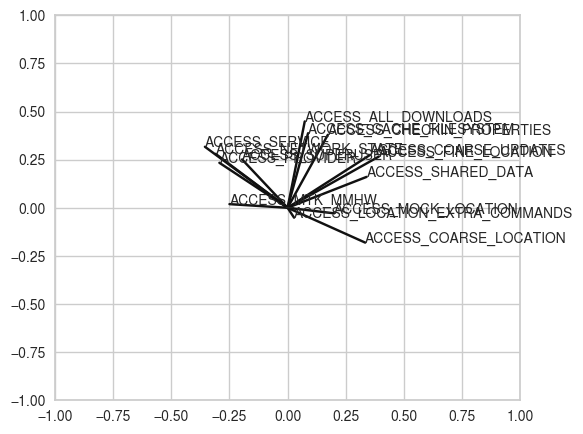

In [378]:
pcs = pca.components_
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # plot line between origin and point (x, y)
    ax.plot([0, x], [0, y], color='k')
    # display the label of the point
    ax.text(x, y, dataset.columns[i], fontsize='10')

## Sporcare il dataset

In questa fase vogliamo dunque sporcare il dataset per valutare come si comportano i modelli rispettivamente i modelli. Per fare ciò si decide di fare test in modi separtai: 
- per il modello di Logistic Regression: mantenendo il dataset nella sua interezza, in queanto fin da subito mostrava buoni comportamente di classificazione senza eliminazione delle feature. In questo modo per ogni tentativo diverso di sporcare il dataset potremmo osservare e valutare l'influenza sulle performance del modello:
    - sia come si comporta il modello solo quando le feature meno importanti sono sporcate (mantenendo tutte le feature del modello)
    - sia che (separatamente) come si comporta il modello quando le feature più importanti sono sporcate (mantenendo però tutte le feature originali del modello)
    - sia che (separatamente) come si comporta il modello mantenendo nel set solo le feature più importanti ed esclusivamente le feature più importanti e sporcandole 
- per il modello di Naive Bayes: si decide di usare direttamente il data-set con solo le feature più importanti, senza considereare quello con tute le feature, (in quanto abbiamo già provato che con troppe feature il modello non funziona bene, rasenta il classificatore casuale). In questo modo almeno riuscremo comunque a verificare la persistenza del modello allo sporcare dei dati

### Inserimento di valori nulli

Come primo tentativo di sporcare i dati vogliamo inserire valori nulli all'interno dei nostri set. Per svolgere questa operazione siccome poi non possiamo rieseguire la classificazione in presenza di valori nulli dedicidiamo di si cancellare alcune celle a caso dalle nostro istanze ma poi le ri-filleremo con la moda della relativa colonna.

Nota: generalmente un buon metodo per il riempimento di valori vuoti è il metodo `KNNImputer` (utilizzato per imputare, ovvero stimare, i valori mancanti nei dati utilizzando un algoritmo basato sul vicinato più prossimo (K-nearest neighbor). Tuttavia, quando tutte le tue feature sono binarie (0/1) come nel nostro caso, la nozione di "distanza" può essere problematica, poiché non è immediatamente chiaro come definire la similarità tra osservazioni basata solo su valori binari. Inoltre, l'imputazione tramite KNN potrebbe non produrre risultati molto significativi quando si trattano feature binarie.

Invece, una strategia più semplice e potenzialmente più appropriata potrebbe essere l'imputazione utilizzando la moda (il valore più frequente) per ciascuna feature.

In [379]:
# Visualizzazione di valori nulli all'interno di una colonna
import missingno as msno

# Autocompletamento di dati mancanti
from sklearn.impute import SimpleImputer

In [380]:
# Metodo per l'inserimento di valori nulli solo in certe colonnne:
def insert_nulls(X_train, features_names, null_percentage):
    # Copia del DataFrame per non modificare l'originale
    X_train_copy = X_train.copy()
    
    # Inserimento di valori nulli nelle colonne specificate
    for feature in features_names:
        if feature in X_train_copy.columns:
            # Calcola il numero di valori nulli da inserire
            num_nulls = int(X_train_copy[feature].size * null_percentage)
            # Seleziona casualmente gli indici delle celle da impostare a null
            null_indices = np.random.choice(X_train_copy.index, size=num_nulls, replace=False)
            # Imposta i valori a null
            X_train_copy.loc[null_indices, feature] = np.nan
    
    return X_train_copy

#### 1. Logistic Regression - sporcare i dati meno significativi

Inseriamo dunque dei valori nulli solo all'interno delle colonne meno significative. 

Per fare ciò partiamo a generare una copia del dataset nelle quali colonne andremo ad inserire i valori nulli, ma solo se queste feature sono comprese nella variabile `less_important_features`

<Axes: >

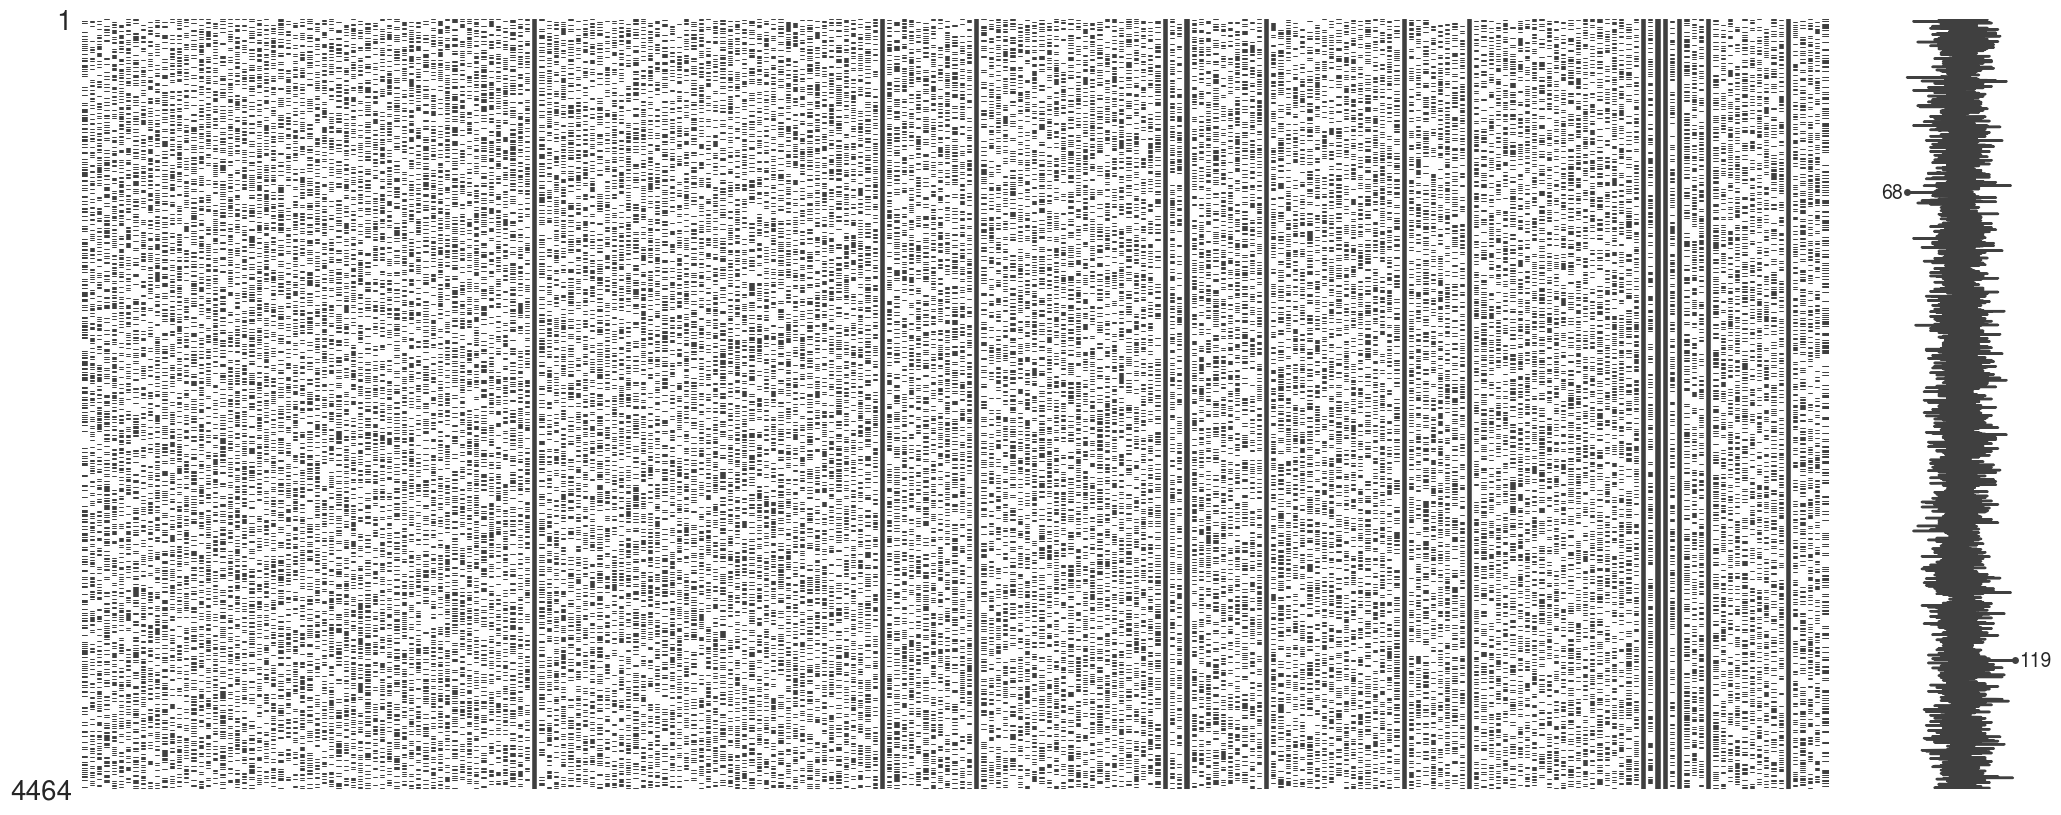

In [381]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = uni_feature.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
inconsistent_uni_feature = insert_nulls(X_train=inconsistent_uni_feature, features_names=less_important_features, null_percentage=0.65)

# visualizzazione valori nulli
msno.matrix(inconsistent_uni_feature)

Dalla visual appena mostrata riusciamo a vedere quanto abbiamo sporcato il dataset. Tutte le colonne contengono ora per il 65% valori mancanti, trnane le 14 colonne più importanti, che sono le colonne rappresentate dalle righe completamente nere, ossia mantengono ancora tutti i valori. 

Poi generiamo nuove variabili di train e test che partono dal dataset contenente tutte le feature appena sporcate

In [382]:
X_train, X_test, y_train, y_test = train_test_split(inconsistent_uni_feature, uni_target, test_size=0.80, random_state=42, stratify=uni_target) 

Ora procediamo con il refill dei valori nulli con la moda

In [383]:
# Crea un imputer che sostituisce i valori mancanti con la moda
imputer = SimpleImputer(strategy='most_frequent')

# Addestra l'imputer sui dati di addestramento
imputer.fit(X_train)

# Imputa i valori mancanti nei dati di addestramento e di test
imputed_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
imputed_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


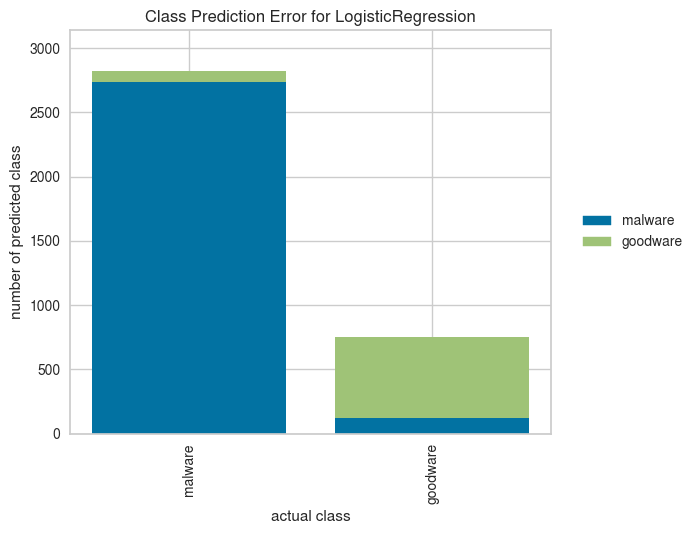

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


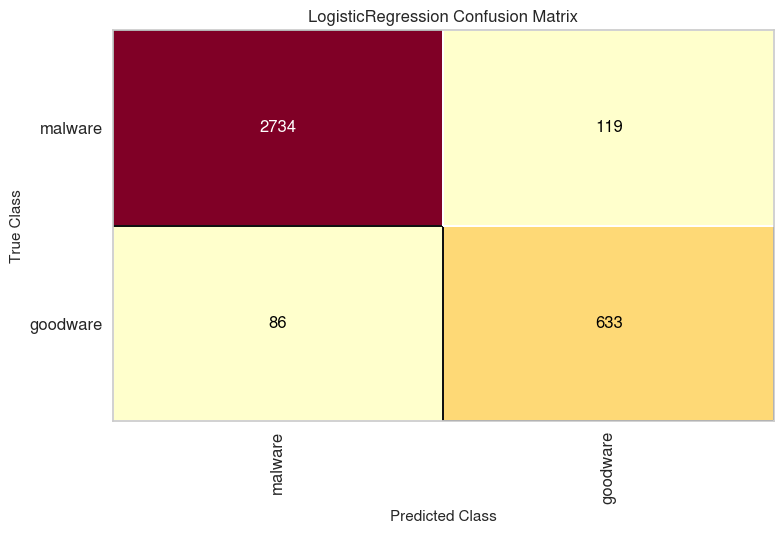

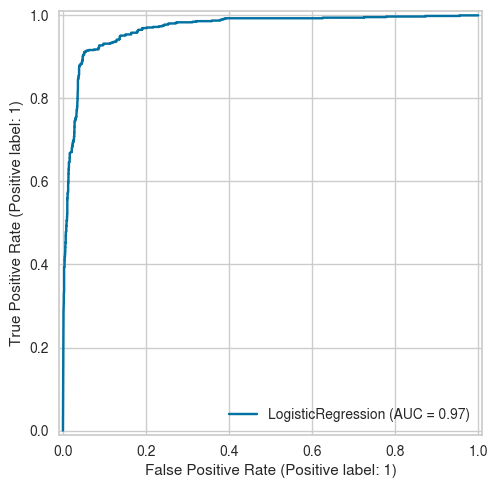


Logistic Regression Results:
Time: 159 ms
F1 Score: 0.94
MCC Score: 0.82
Precision: 0.94



In [384]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(imputed_train, imputed_test, y_train, y_test)["logreg"]
print_results_logreg(logreg)

Come da aspettarsi le performance non calano quasi per nulla, in quanto tutti i dati ncessari per la classicazione rimangono intatti. 

#### 2. Logistic Regression - sporcare i dati più significativi (mantenendo altre feature)

Inseriamo questa volta dei valori nulli solo all'interno delle colonne più significative per vedere la risposta del modello.

Per fare ciò partiamo a generare una copia del dataset nelle quali colonne andremo ad inserire i valori nulli, ma solo se queste feature sono comprese nella variabile `most_important_features_columns`

<Axes: >

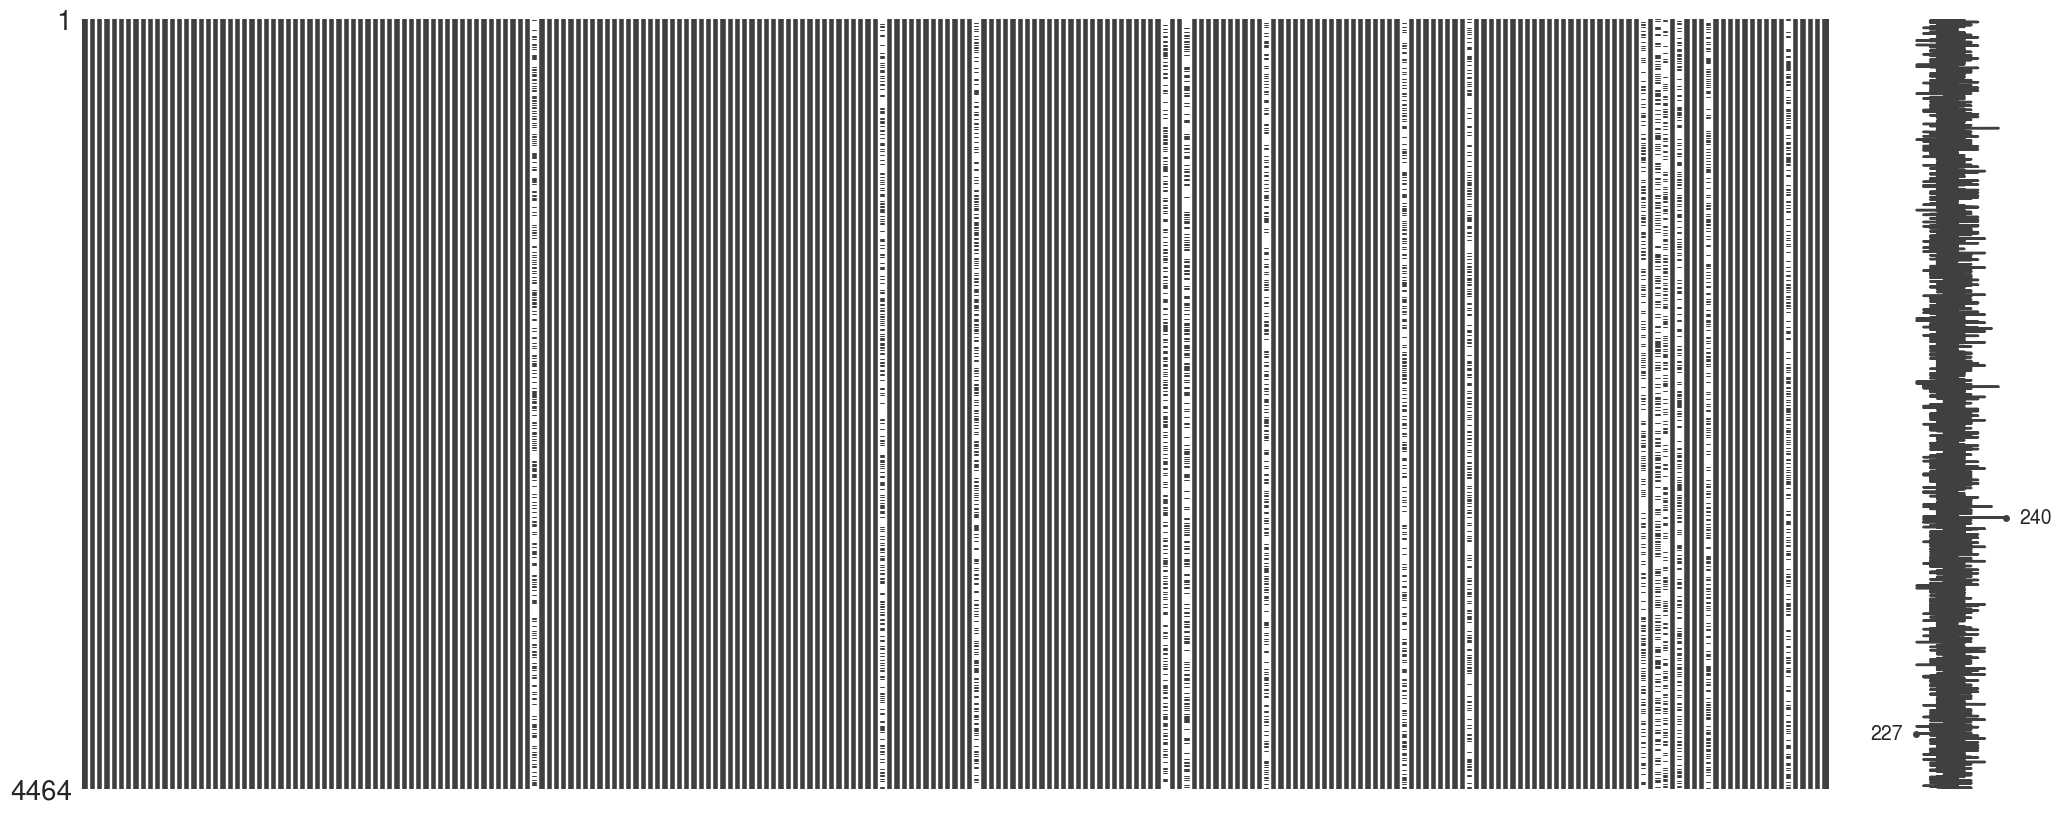

In [385]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = uni_feature.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
inconsistent_uni_feature = insert_nulls(X_train=inconsistent_uni_feature, features_names=most_important_features_columns, null_percentage=0.65)

# visualizzazione valori nulli
msno.matrix(inconsistent_uni_feature)

Dalla visual appena mostrata riusciamo a vedere quanto abbiamo sporcato il dataset. 

Diversamente da prima ora la maggior parte delle colonne mantengono i loro dati intatti. Invece le 14 colonne più significative contengono ora per il 65% valori mancanti.

Siamo dunque ora pronti a generare nuove variabili di train e test che partono dal dataset contenente tutte le feature appena sporcate

In [386]:
X_train, X_test, y_train, y_test = train_test_split(inconsistent_uni_feature, uni_target, test_size=0.80, random_state=42, stratify=uni_target) 

Ora procediamo con il refill dei valori nulli con la moda

In [387]:
# Crea un imputer che sostituisce i valori mancanti con la moda
imputer = SimpleImputer(strategy='most_frequent')

# Addestra l'imputer sui dati di addestramento
imputer.fit(X_train)

# Imputa i valori mancanti nei dati di addestramento e di test
imputed_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
imputed_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


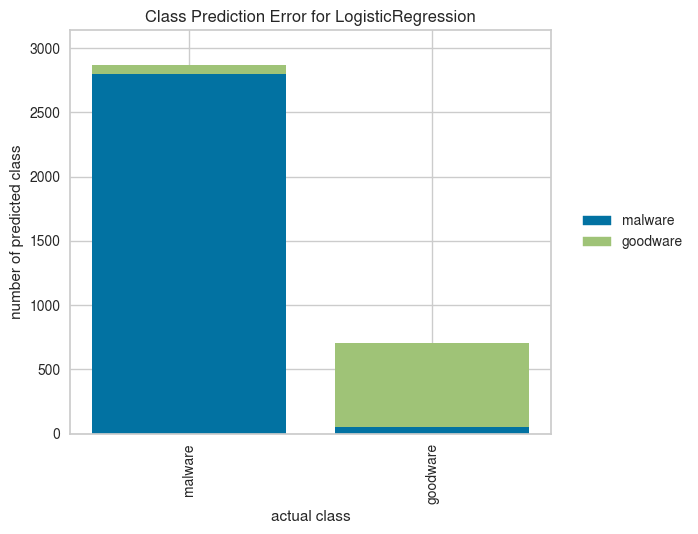

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


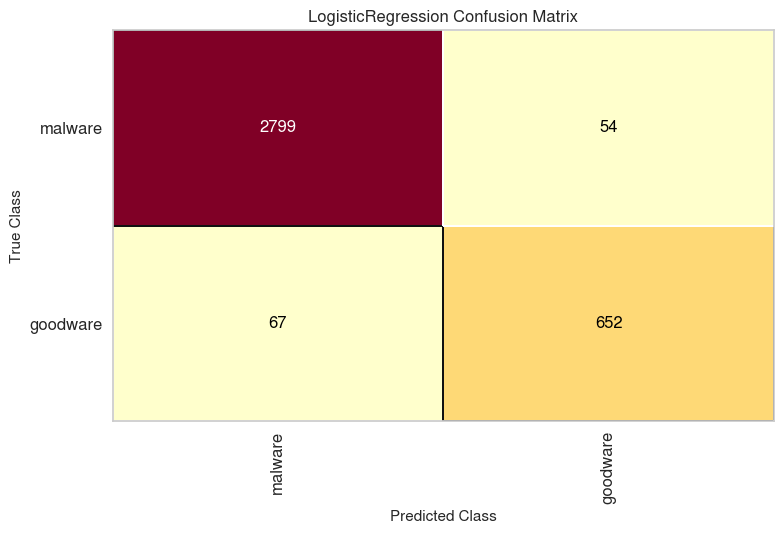

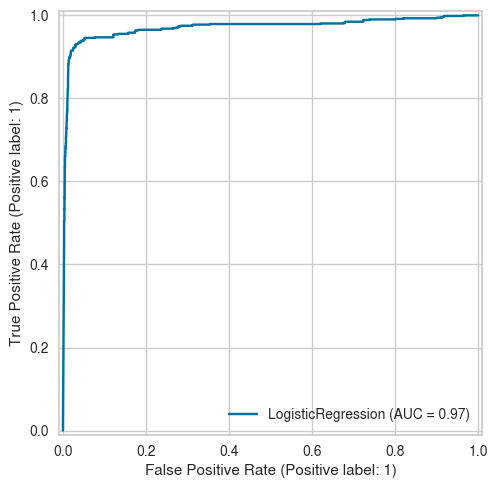


Logistic Regression Results:
Time: 264 ms
F1 Score: 0.97
MCC Score: 0.89
Precision: 0.97



In [388]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(imputed_train, imputed_test, y_train, y_test)["logreg"]
print_results_logreg(logreg)

Questo risultato non ci sorprende più di tanto, in quanto già facendo la preparazione dei dati ci siamo subito accorti che c'erano molte feature che condividevano lo stesso valore informativo. È possibile che tra le 14 che abbiamo sporcato molte di queste, se non addirittura tutte possano avere una colonna con lo stesso identico valore informativo che, in questo caso, è rimasta intatta. Dunque è molto facile aspettarsi che tra il metodo di imputer basato sulla moda che ha ricostruito i dati e le possibili colonne duplicate i classificatore riuscisse comunque a trovare un modo per classificare bene il target.

#### 3. Logistic Regression - sporcare i dati più significativi (senza altre feature)

In questo caso partimo direttamente generare una copia del dataset che contiene solo le feature più importanti `most_important_features` e poi andremo a sporcarle tutte

<Axes: >

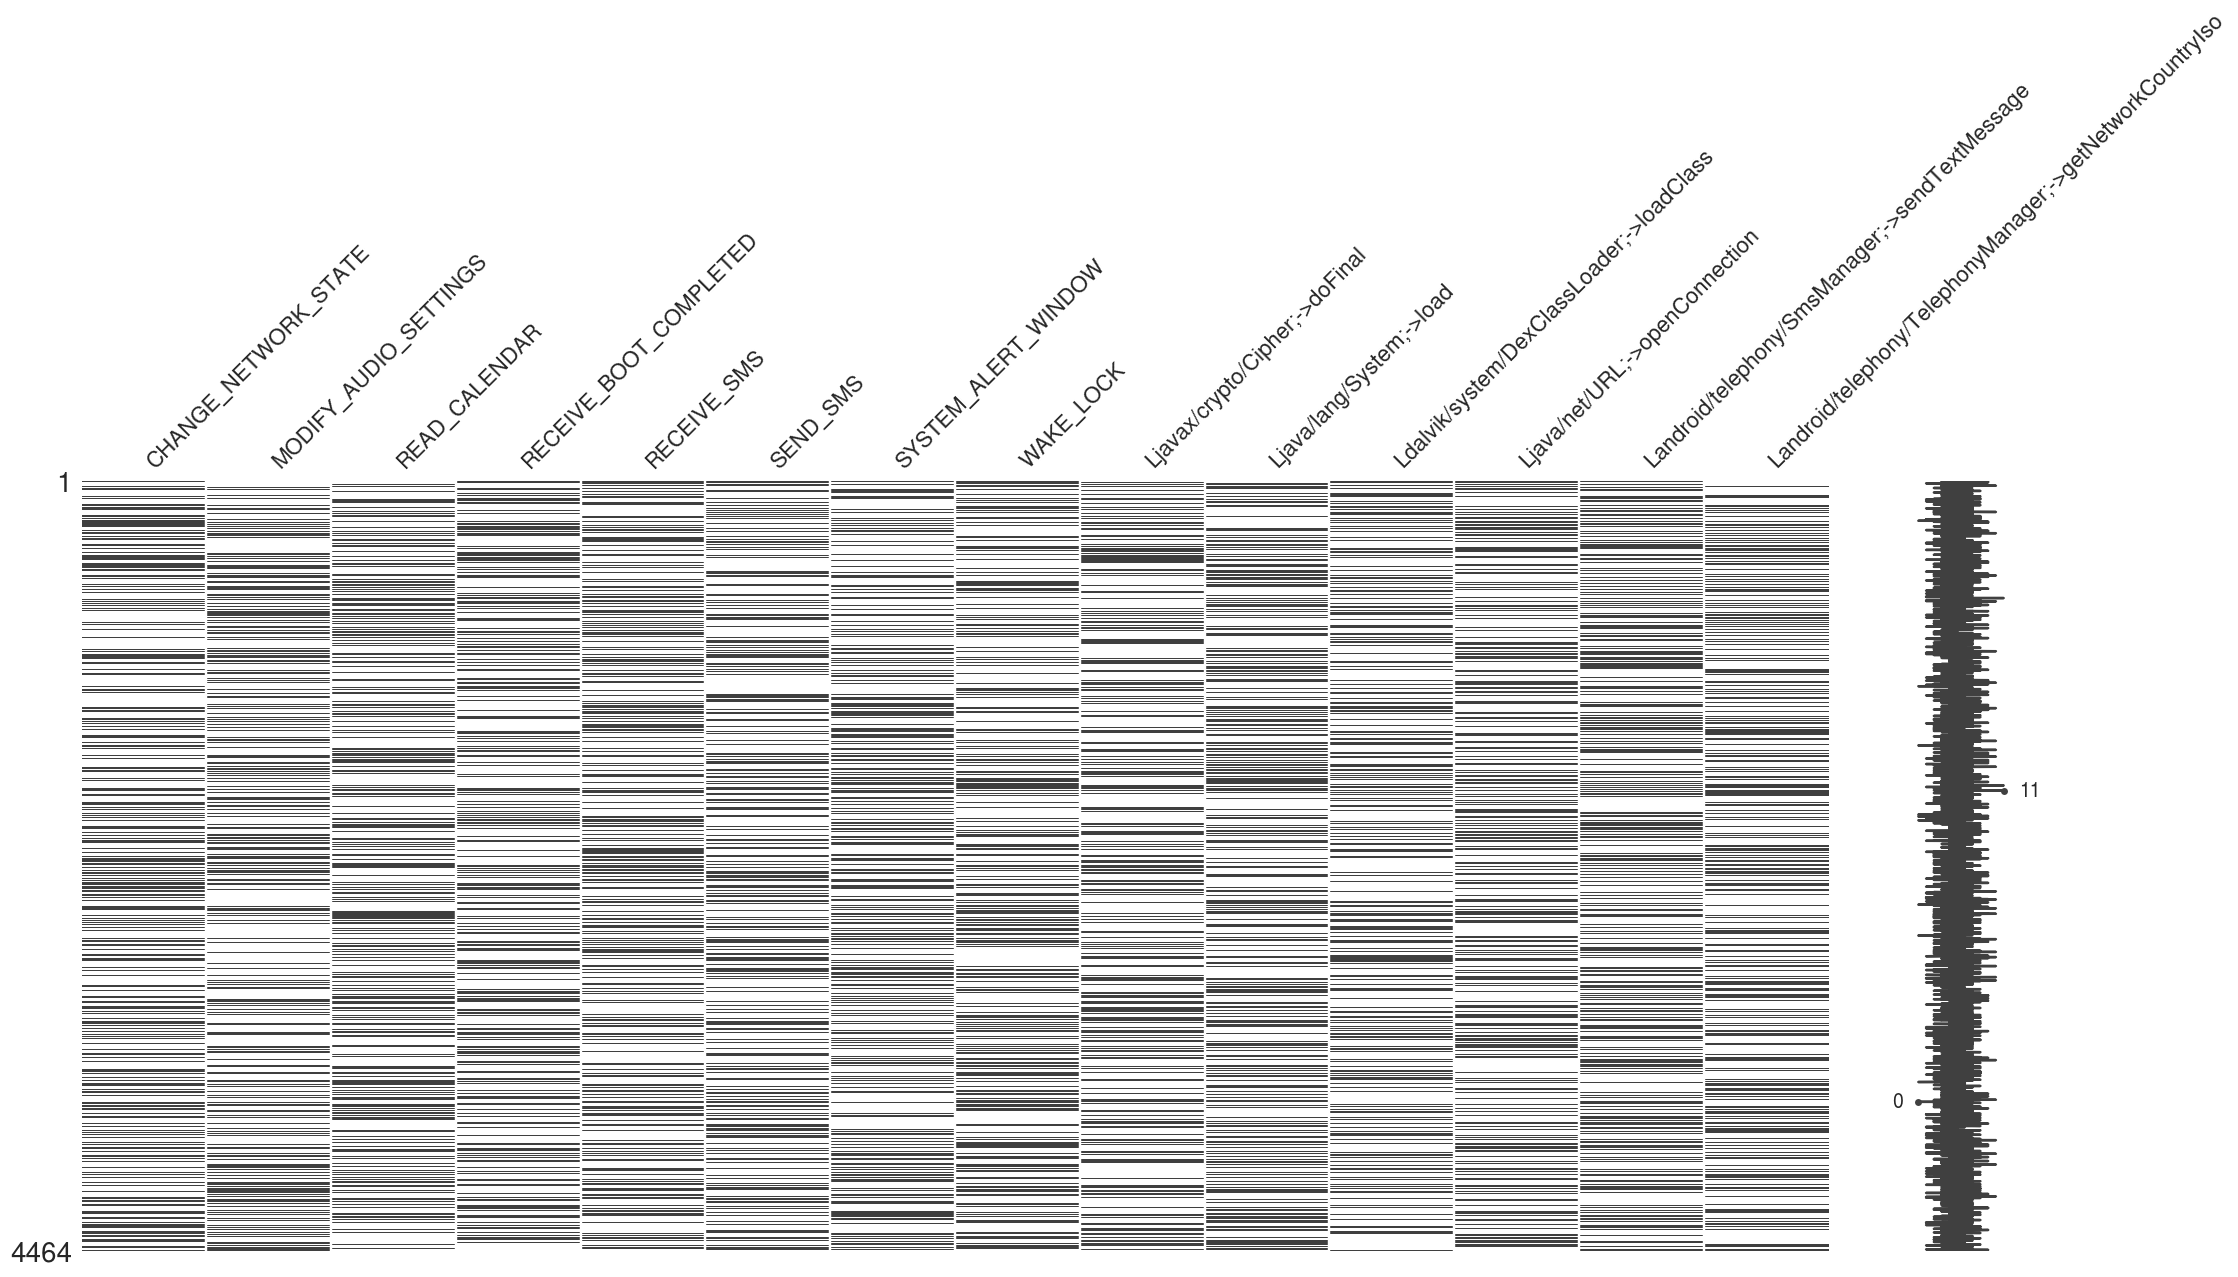

In [389]:
# creao una copia del dataset con tutte le feature
inconsistent_uni_feature = most_important_features.copy()

# sporco la copia del suddetto dataset inserendo valori nulli.
inconsistent_uni_feature = insert_nulls(X_train=inconsistent_uni_feature, features_names=most_important_features_columns, null_percentage=0.65)

# visualizzazione valori nulli
msno.matrix(inconsistent_uni_feature)

Abbiamo tenuto solo le 14 colonne più significative ma ora tutte le colonne ora contengono ora per il 65% valori mancanti

Generiamo ora le nuove variabili di train e test che partono dal dataset contenente tutte le feature appena sporcate

In [390]:
X_train, X_test, y_train, y_test = train_test_split(inconsistent_uni_feature, uni_target, test_size=0.80, random_state=42, stratify=uni_target) 

Ora procediamo con il refill dei valori tramite il metodo `KNNImputer` 

In [391]:
# Crea un imputer che sostituisce i valori mancanti con la moda
imputer = SimpleImputer(strategy='most_frequent')

# Addestra l'imputer sui dati di addestramento
imputer.fit(X_train)

# Imputa i valori mancanti nei dati di addestramento e di test
imputed_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
imputed_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


Fatto questo possiamo ora passare alla valutazione, andando a verificare le nuove prestazioni del modello di Regressione Logistica: 


 _                 _     _   _        _____                              _             
| |               (_)   | | (_)      |  __ \                            (_)             
| |     ___   __ _ _ ___| |_ _  ___  | |__) |___  __ _ _ __ ___  ___ ___ _  ___  _ __  
| |    / _ \ / _` | / __| __| |/ __| |  _  // _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
| |___| (_) | (_| | \__ \ |_| | (__  | | \ \  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|______\___/ \__, |_|___/\__|_|\___| |_|  \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
              __/ |                               __/ |                                
             |___/                               |___/                                


/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


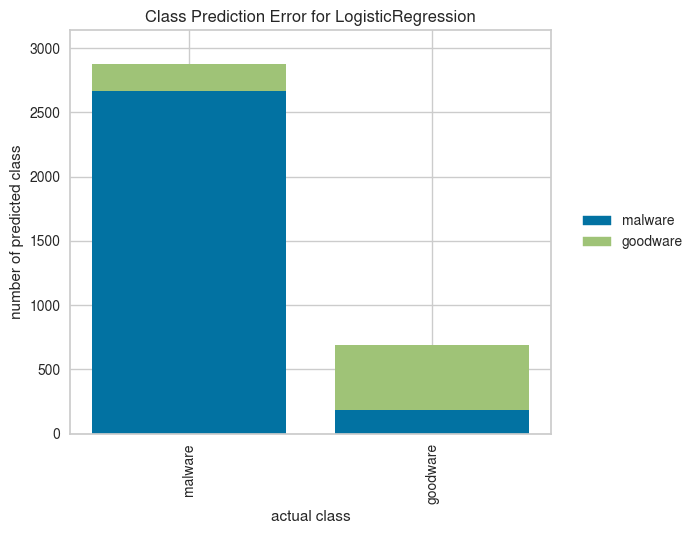

/home/cava/Documents/Repos/Notebooks/Progetto Architettura Dati/myenv/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


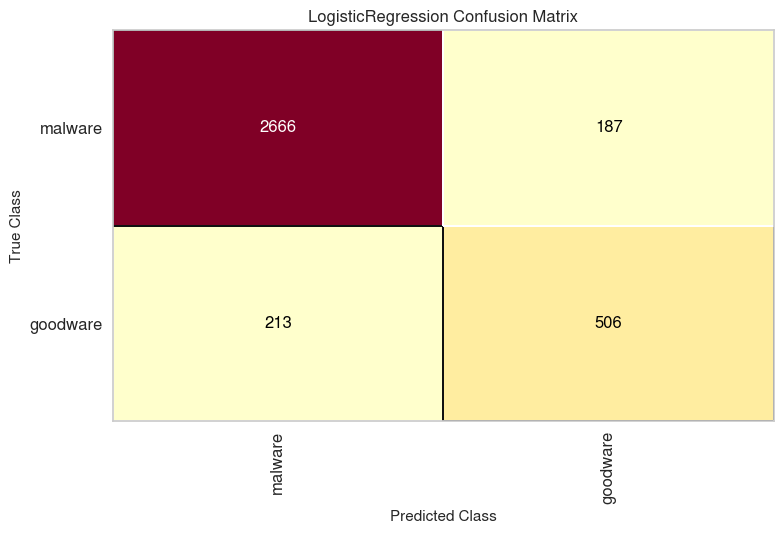

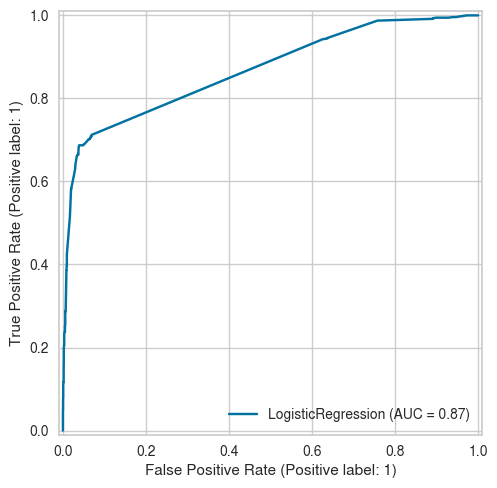


Logistic Regression Results:
Time: 11 ms
F1 Score: 0.89
MCC Score: 0.65
Precision: 0.89



In [392]:
# valutazione tramire Logistic regression delle nuove performance
logreg = evaluate_with_Logistic_Regression(imputed_train, imputed_test, y_train, y_test)["logreg"]
print_results_logreg(logreg)

## Roba random che ho impalato in fondo

In [393]:
#prima sostituisco nel target dei valori numerici 0 ed 1 alle stringhe "goodware" e "malware"
uni_target = uni_target.replace(to_replace=["goodware", "malware"], value=[1, 0])
print(uni_target)

X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

      Label
0         0
1         0
2         0
3         0
4         0
...     ...
4460      1
4461      1
4462      1
4463      1
4464      1

[4464 rows x 1 columns]


In [394]:
y_train = y_train.replace(to_replace=["goodware", "malware"], value=[1, 0])
y_test = y_test.replace(to_replace=["goodware", "malware"], value=[1, 0])

### Rimuovere colonne con varianza 0

This technique eliminates features that have a variation below a specified threshold. When a characteristic doesn't vary much within itself, it has low predictive potential, according to the theory.

In order to use this technique, it's better if we first normalize our data using scikit learn's `Normalizer`. the difference between `normalizer` and `standardScaler` is that Normalizer does not remove the mean and scale by deviation but scales the whole row to unit norm. Ma noi abbiamo già che tutto il dataset è normalizzato quindi non ci  interessa fare questo step 

**yet another time, to reduce test data leakage, I'm fitting scaler on training data and then transform both train and test sets.**

In [395]:
selector = VarianceThreshold()
selector.fit(X_train)

VarianceThreshold()

In [396]:
mask = selector.get_support()
columns = X_train.columns

# Aggiornamento delle feature più importanti 
# (si droppano quelle meno importanti appena trovate da quelle most_important trovate precedentemente)
# Crea un set di nomi delle colonne più importanti
least_important_features_columns = columns[mask]
most_important_features = uni_feature
# Droppa le colonne da most_important_features se ce ne sono
if len(least_important_features_columns)>0:
    most_important_features.drop(columns=least_important_features_columns, inplace=True)

n_features2 = len(most_important_features)
print(f'Dopo aver droppato { len(least_important_features_columns) } features, rimangono {most_important_features.shape[1]} features.')

Dopo aver droppato 14 features, rimangono 227 features.


In [397]:
most_important_features

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledApplications,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [398]:
X_train, X_test, y_train, y_test = train_test_split(most_important_features, uni_target, test_size=0.80, random_state=42, stratify=uni_target)

# lists to record time and scores
f1scores = []
mccscores = []
times = []

time, f1score, mccscore = evaluate(train_df = X_train, test_df = X_test, train_target=y_train, test_target=y_test)
print(f' Training time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

TypeError: evaluate() got an unexpected keyword argument 'train_df'